In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
%matplotlib inline

import lightgbm as lgb
import gc
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # 初期状態のメモリ消費量確認 （=value.nbytes)
    start_mem = df.memory_usage().sum() / 1024**2    
    
    # 各列について
    for col in df.columns:
        col_type = df[col].dtypes
        # 列のタイプがint16~64 or float16~64なら
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            # int型なら
            if str(col_type)[:3] == 'int':
                # 列の全値がint8型の範囲に収まるなら列の値をint8型に変換
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 列の全値がint16型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 列の全値がint32型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 列の全値がint64型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float型なら
            else:
                # 列の全値がfloat32型の範囲に収まるなら列の値をfloat32型に変換
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 列の値をfloat64型に
                else:
                    df[col] = df[col].astype(np.float64)
    # 型変換の後のメモリ消費量を確認
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
folder_path = './ieee-fraud-detection'
train_identity = pd.read_csv(f'{folder_path}/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
sample_sub = pd.read_csv(f'{folder_path}/sample_submission.csv')

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1049.21 Mb (46.5% reduction)
Mem. usage decreased to 899.75 Mb (46.4% reduction)


In [6]:
base_columns = list(train)

# Add feature

In [8]:
def encode_trigonometric(df, cols):
    for col in cols:
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [9]:
m_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [10]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
start_date = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [11]:
def add_feature(df):
    df['TransactionAmt_mean_diff'] = df['TransactionAmt'] - df['TransactionAmt'].mean()
    df['TransactionAmt_std_normalize'] = df['TransactionAmt'] / df['TransactionAmt'].std()
    
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    #df['TransactionAmt_to_mean_card2'] = df['TransactionAmt'] / df.groupby(['card2'])['TransactionAmt'].transform('mean')
    #df['TransactionAmt_to_mean_card3'] = df['TransactionAmt'] / df.groupby(['card3'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
    #df['TransactionAmt_to_mean_card5'] = df['TransactionAmt'] / df.groupby(['card5'])['TransactionAmt'].transform('mean')
    #df['TransactionAmt_to_mean_card6'] = df['TransactionAmt'] / df.groupby(['card6'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
    #df['TransactionAmt_to_std_card2'] = df['TransactionAmt'] / df.groupby(['card2'])['TransactionAmt'].transform('std')
    #df['TransactionAmt_to_std_card3'] = df['TransactionAmt'] / df.groupby(['card3'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')
    #df['TransactionAmt_to_std_card5'] = df['TransactionAmt'] / df.groupby(['card5'])['TransactionAmt'].transform('std')
    #df['TransactionAmt_to_std_card6'] = df['TransactionAmt'] / df.groupby(['card6'])['TransactionAmt'].transform('std')
    
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    # df['TransactionAmt'] = np.log(df['TransactionAmt'])
    
    df['card1_count_full'] = df['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
    
    df['uid'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid2'] = df['uid'].astype(str) + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    df['uid4'] = df['uid3'].astype(str) + '_' + df['P_emaildomain'].astype(str)
    df['uid5'] = df['uid3'].astype(str) + '_' + df['R_emaildomain'].astype(str)
    
    
    df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
    df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('mean')
    df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
    df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('std')
    
    df['D15_to_mean_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('mean')
    df['D15_to_mean_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('mean')
    df['D15_to_std_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('std')
    df['D15_to_std_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('std')
    
    df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
    df['D15_to_mean_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('mean')
    df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')
    df['D15_to_std_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('std')
    
    df['M_sum'] = df[m_cols].sum(axis=1)
    df['M_na'] = df[m_cols].isna().sum(axis=1)
    
    uknown = 'email_not_provided'
    df['P_emaildomain'] = df['P_emaildomain'].fillna(uknown)
    df['R_emaildomain'] = df['R_emaildomain'].fillna(uknown)
    df['email_check'] = np.where((df['P_emaildomain'] == df['R_emaildomain']) & (df['P_emaildomain'] != uknown), 1, 0)
    df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
    df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)
    
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ' '.join([i for i in x if i.isnumeric()]))
    
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ' '.join([i for i in x if i.isnumeric()]))
    
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    
    #df['weekdays'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
    #df['hours'] = np.floor(df['TransactionDT'] / 3600) % 24
    
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    #df['D9'] = np.where(df['D9'].isna(), 0, 1)
    
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = df['is_december']==12
    
    df['is_holiday'] = df['DT'].dt.date.astype('datetime64').isin(us_holidays)
    
    trigonometric_cols = ['DT_hour', 'DT_day_week', 'DT_day']
    df = encode_trigonometric(df, trigonometric_cols)

In [12]:
add_feature(train)
add_feature(test)

In [13]:
train = train.drop('DT', axis=1)
test = test.drop('DT', axis=1)

In [14]:
def values_normalization(df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            df[col] = df[col].astype(float)
            
            temp_min = df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()
            
            temp_max = df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()
            
            temp_mean = df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()
            
            temp_std = df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()
            
            df['temp_min'] = df[period].map(temp_min)
            df['temp_max'] = df[period].map(temp_max)
            df['temp_mean'] = df[period].map(temp_mean)
            df['temp_std'] = df[period].map(temp_std)
            
            df[new_col + '_min_max'] = (df[col] - df['temp_min']) / (df['temp_max'] - df['temp_min'])
            df[new_col + '_std_score'] = (df[col] - df['temp_mean']) / (df['temp_std'])
            del df['temp_min'], df['temp_max'], df['temp_mean'], df['temp_std']
            
    return df

In [15]:
def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train[[col]], test[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col] = test[col].map(fq_encode)
        else:
            train[col + '_fq_enc'] = train[col].map(fq_encode)
            test[col + '_fq_enc'] = test[col].map(fq_encode)
        
    return train, test

In [16]:
def timeblock_frequency_encoding(train, test, periods, columns, with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            train[new_col] = train[col].astype(str) + '_' + train[period].astype(str)
            test[new_col] = test[col].astype(str) + '_' + test[period].astype(str)
            
            temp_df = pd.concat([train[[new_col]], test[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()
            
            train[new_col] = train[new_col].map(fq_encode)
            test[new_col] = test[new_col].map(fq_encode)
            
            if only_proportions:
                train[new_col] = train[new_col] / train[period + '_total']
                test[new_col] = test[new_col] / test[period + '_total']
                
            if with_proportions:
                train[new_col + '_proportions'] = train[new_col] / train[period + '_total']
                test[new_col + '_proportions'] = test[new_col] / test[period + '_total']
                
    return train, test

In [17]:
def uid_aggregation(train, test, main_columns, uids, aggregations):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train[[col, main_column]], test[[col, main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                
                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()
                train[new_col_name] = train[col].map(temp_df)
                test[new_col_name] = test[col].map(temp_df)
                
    return train, test

In [18]:
for col in ['DT_M', 'DT_W', 'DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
    train[col + '_total'] = train[col].map(fq_encode)
    test[col + '_total'] = test[col].map(fq_encode)

In [19]:
valid_card = pd.concat([train[['card1']], test[['card1']]])
valid_card = valid_card['card1'].value_counts()
valid_card = valid_card[valid_card > 2]
valid_card = list(valid_card.index)

train['card1'] = np.where(train['card1'].isin(test['card1']), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(train['card1']), test['card1'], np.nan)

train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col] = np.where(test[col].isin(train[col]), test[col], np.nan)
    
i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3', 'uid4', 'uid5']
train, test = frequency_encoding(train, test, i_cols, self_encoding=False)

In [20]:
for df in [train, test]:
    df['bank_type'] = df['card3'].astype(str) + '_' + df['card5'].astype(str)
    
encoding_mean = {
        1: ['DT_D', 'DT_hour', '_hour_dist', 'DT_hour_mean'],
        2: ['DT_W', 'DT_day_week', '_week_day_dist', 'DT_day_week_mean'],
        3: ['DT_M', 'DT_day', '_month_day_dist', 'DT_day_mean']}
encoding_best = {
        1: ['DT_D', 'DT_hour', '_hour_dist_best', 'DT_hour_best'],
        2: ['DT_W', 'DT_day_week', '_week_day_dist_best', 'DT_day_week_best'],
        3: ['DT_M', 'DT_day', '_month_day_dist_best', 'DT_day_best']}

for col in ['card3', 'card5', 'bank_type']:
    for df in [train, test]:
        for encode in encoding_mean:
            encode = encoding_mean[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) + '_' + df[encode[0]].astype(str)
            temp_dict = df.groupby([new_col])[encode[1]].agg(['mean']).reset_index().rename(columns={'mean': encode[3]})
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[3]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)
            
        for encode in encoding_best:
            encode = encoding_best[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) + '_' + df[encode[0]].astype(str)
            temp_dict = df.groupby([col, encode[0], encode[1]])[encode[1]].agg(['count']).reset_index().rename(columns={'count': encode[3]})
            temp_dict.sort_values(by=[col, encode[0], encode[3]], inplace=True)
            temp_dict = temp_dict.drop_duplicates(subset=[col, encode[0]], keep='last')
            temp_dict[new_col] = temp_dict[col].astype(str) + '_' + temp_dict[encode[0]].astype(str)
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[1]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

In [21]:
i_cols = ['bank_type']
periods = ['DT_M', 'DT_W', 'DT_D']

train, test = timeblock_frequency_encoding(train, test, periods, i_cols, with_proportions=False, only_proportions=True)

In [22]:
i_cols = ['D' + str(i) for i in range(1, 16)]
uids = ['uid', 'uid2', 'uid3', 'uid4', 'uid5', 'bank_type']
aggregations = ['mean', 'std']

train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

for df in [train, test]:
    for col in i_cols:
        df[col] = df[col].clip(0)
    
    df['D9_not_na'] = np.where(df['D9'].isna(), 0, 1)
    df['D8_not_same_day'] = np.where(df['D8'] >= 1, 1, 0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0) - df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist'] - df['D9'] ** 2) ** 0.5)
    df['D8'] = df['D8'].fillna(-1).astype(int)
    
i_cols.remove('D1')
i_cols.remove('D2')
i_cols.remove('D9')
periods = ['DT_D', 'DT_W', 'DT_M']
for df in [train, test]:
    df = values_normalization(df, periods, i_cols)

for col in ['D1', 'D2']:
    for df in [train, test]:
        df[col + '_scaled'] = df[col] / train[col].max()
        
i_cols = ['D' + str(i) for i in range(1, 16)]
train, test = frequency_encoding(train, test, i_cols, self_encoding=True)

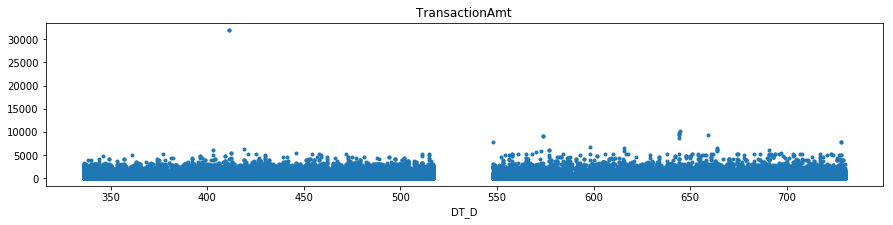

In [23]:
i_cols = ['TransactionAmt']
periods = ['DT_D']

temp_df = pd.concat([train[['TransactionDT'] + i_cols + periods], test[['TransactionDT'] + i_cols + periods]])
for period in periods:
    for col in i_cols:
        for df in [temp_df]:
            df.set_index(period)[col].plot(style='.', title=col, figsize=(15, 3))
            plt.show()
            
train['TransactionAmt'] = train['TransactionAmt'].clip(0, 5000)
test['TransactionAmt'] = test['TransactionAmt'].clip(0, 5000)

train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check'] = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

i_cols = ['TransactionAmt']
uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3', 'uid4', 'uid5', 'bank_type']
aggregations = ['mean', 'std']

train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

periods = ['DT_D', 'DT_W', 'DT_M']
for df in [train, test]:
    df = values_normalization(df, periods, i_cols)
    
train['product_type'] = train['ProductCD'].astype(str) + '_' + train['TransactionAmt'].astype(str)
test['product_type'] = test['ProductCD'].astype(str) + '_' + test['TransactionAmt'].astype(str)

i_cols = ['product_type']
periods = ['DT_D', 'DT_W', 'DT_M']
train, test = timeblock_frequency_encoding(train, test, periods, i_cols, with_proportions=False, only_proportions=True)
train, test = frequency_encoding(train, test, i_cols, self_encoding=True)

train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [24]:
i_cols = ['C' + str(i) for i in range(1, 15)]

train, test = frequency_encoding(train, test, i_cols, self_encoding=False)

for df in [train, test]:
    for col in i_cols:
        max_value = train[train['DT_M']==train['DT_M'].max()][col].max()
        df[col] = df[col].clip(None, max_value)

In [25]:
i_cols = ['DeviceInfo', 'DeviceInfo_device', 'DeviceInfo_version', 
         'id_30', 'id_30_device', 'id_30_version', 'id_31', 'id_31_device', 'id_33']

train, test = frequency_encoding(train, test, i_cols, self_encoding=True)

In [26]:
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain',
                'P_emaildomain__C2', 'card2__dist1', 'card1__card5', 'card2__id_20',
                'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

for feature in ['id_34', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [27]:
i_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6',
          'uid', 'uid2', 'uid3', 'uid4', 'uid5', 'addr1', 'addr2', 'P_emaildomain']
for df in [train, test]:
    for col in i_cols:
        df['next_' + col + '_DT'] = df.groupby([col])['TransactionDT'].shift(-1)
        df['next_' + col + '_diff'] = df['next_' + col + '_DT'] - df['TransactionDT']
        df['next_' + col + '_diff'] = df['next_' + col + '_diff'].fillna(df['next_' + col + '_diff'].max())
        df = df.drop('next_' + col + '_DT', axis=1)

        df['previous_' + col + '_DT'] = df.groupby([col])['TransactionDT'].shift(1)
        df['previous_' + col + '_diff'] = df['TransactionDT'] - df['previous_' + col + '_DT']
        df['previous_' + col + '_diff'] = df['previous_' + col + '_diff'].fillna(df['previous_' + col + '_diff'].max())
        df = df.drop('previous_' + col + '_DT', axis=1)

In [28]:
i_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'P_emaildomain']
temp_df = pd.concat([train[i_cols], test[i_cols]])
for i, col in enumerate(i_cols):
    for j in range(i + 1, len(i_cols)):
        to_unique = i_cols[j]
        unique_encode = temp_df.groupby([col])[to_unique].nunique().to_dict()
        train[col + '_by_' + to_unique + '_countuniq'] = train[col].map(unique_encode)
        test[col + '_by_' + to_unique + '_countuniq'] = test[col].map(unique_encode)

# ()

In [ ]:
def check_cor_and_remove(train, test, i_cols, new_columns, remove=False):
    print('Correlations', '#' * 10)
    for col in new_columns:
        cor_cof = np.corrcoef(train[TARGET])

In [308]:
i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3']
for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col, 'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [309]:
ii_cols = ['card1', 'card2', 'card3', 'card5',
           'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
          'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'addr1', 'addr2', 'dist1', 'dist2',
          'P_emaildomain', 'R_emaildomain',
           'DeviceInfo', 'id_30', 'id_33', 'uid'
           , 'DeviceInfo_device', 'DeviceInfo_version', 'id_30_device', 'id_30_version', 'id_31_device'
           , 'uid2', 'uid3'
          ]

for col in ii_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
    train[col + '_fq_enc'] = train[col].map(fq_encode)
    test[col + '_fq_enc'] = test[col].map(fq_encode)
    
for col in ['DT_M', 'DT_W', 'DT_D']:
    temp_df = pd.concat([train[[col]], test[col]])
    fq_encode = temp_df[col].value_counts().to_dict()
    train[col + '_total'] = train[col].map(fq_encode)
    test[col + '_total'] = test[col].map(fq_encode)

In [83]:
for df in [train_, test_]:
    temp_dict = df.groupby(['ProductCD'])['TransactionAmt'].agg(['mean']).reset_index().rename(columns={'mean': 'Amt_mean'})
    temp_dict.index = temp_dict['ProductCD'].values
    temp_dict = temp_dict['Amt_mean'].to_dict()
    df['TransactionAmt_ProductCD'] = df['TransactionAmt'] - df['ProductCD'].map(temp_dict)

In [107]:
i_cols = ['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'dist2',
          'P_emaildomain']
for col in i_cols:
    train_[col + '_isnan'] = train_[col].isnull()
    test_[col + '_isnan'] = test_[col].isnull()

In [105]:
periods = [1, 5, 10, 30, 50]
i_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
for col in i_cols:
    for period in periods:
        for df in [train_, test_]:
            #df[col + '_previous_' + str(period) + '_days_count'] = df.groupby([col])['TransactionID'].rolling(center=False, window=period).count().reset_index(drop=True)
            #df[col + '_previous_' + str(period) + '_days_count'] = df.groupby([col])[col + '_previous_' + str(period) + '_days_count'].shift(periods=1)
            
            df[col + '_next_' + str(period) + '_days_count'] = df.iloc[::-1].groupby([col], sort=False)['TransactionID'].rolling(center=False, window=period).count().reset_index(drop=True)
            df[col + '_next_' + str(period) + '_days_count'] = df.groupby([col])[col + '_next_' + str(period) + '_days_count'].shift(periods=-1).iloc[::-1].values

In [82]:
train_ = train.copy()
test_ = test.copy()

In [83]:
periods = ['DT_M', 'DT_W', 'DT_D']
i_cols = ['uid']
train_, test_ = timeblock_frequency_encoding(train_, test_, periods, i_cols, with_proportions=False, only_proportions=True)

In [70]:
train_.to_csv('train.csv')
test_.to_csv('test.csv')

# Add Target feature

In [84]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)

In [85]:
target_mean = train_['isFraud'].mean()
i_cols = ['ProductCD', 'card1_fq_enc', 'card2', 'card3', 'card5',
          'uid_fq_enc', 'uid2_fq_enc', 'uid3_fq_enc', 'uid4_fq_enc', 'uid5_fq_enc',
          'addr1', 'addr2', 'P_emaildomain', 'product_type_fq_enc', 'bank_type',
         'DeviceInfo_device_fq_enc']
for col in i_cols:
    train_[col + '_target_enc'] = target_mean
    
    for i, (previous_index, current_index) in enumerate(kf.split(train_)):
        
        if i == 0:
            continue
            
        else:
            train_previous = train_.iloc[previous_index]
            col_num = train_.columns.get_loc(col + '_target_enc')
            
            temp_dict = train_previous.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_target_enc'].to_dict()
            
            train_.iloc[current_index, col_num] = train_.iloc[current_index][col].map(temp_dict)
    
    temp_dict = train_.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_enc'].to_dict()
    test_[col + '_target_enc'] = test_[col].map(temp_dict)

# Preprocessing

In [30]:
def col_drop(df):
    # null or not null で特徴になる？
    null_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
    return null_cols, big_top_value_cols, one_value_cols

In [86]:
null_cols_train, big_top_value_cols_train, one_value_cols_train = col_drop(train_)
null_cols_test, big_top_value_cols_test, one_value_cols_test = col_drop(test_)

cols_to_drop = list(set(null_cols_train + null_cols_test + big_top_value_cols_train + big_top_value_cols_test + one_value_cols_train + one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

103

In [87]:
train_ = train_.drop(cols_to_drop, axis=1)
test_ = test_.drop(cols_to_drop, axis=1)

# LabelEncoding

In [88]:
for col in tqdm_notebook(train_.columns):
    if train_[col].dtype == 'object' and col != 'isFraud':
        le = LabelEncoder()
        le.fit(list(train_[col].astype(str).values) + list(test_[col].astype(str).values))
        train_[col] = le.transform(list(train_[col].astype(str).values))
        test_[col] = le.transform(list(test_[col].astype(str).values))

# Define X, y for modeling

In [34]:
rm_cols = ['isFraud', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day',
          'DT_D_total', 'DT_W_total', 'DT_M_total', 'uid', 'uid2', 'uid3', 'uid4', 'uid5',
           'bank_type', 'id_30', 'id_31', 'id_33']

In [35]:
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_)).difference(base_columns + rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_[i], train_[i])[1])
    
features_check = pd.Series(features_check, index=columns_to_check).sort_values()
features_discard = list(features_check[features_check==0].index)
print(len(features_discard))

# features_discard = []

features_columns = [col for col in list(train_) if col not in rm_cols + features_discard]

129


In [36]:
test_ = test_[features_columns]
features_columns.append('isFraud')
train_ = train_[features_columns]

# train_all

In [89]:
X = train_.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_.sort_values('TransactionDT')['isFraud'].astype(bool)
X_test = test_.drop(['TransactionDT', 'TransactionID'], axis=1)
del train_, test_
gc.collect()
#test = test[['TransactionDT', 'TransactionID']]

105

In [90]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

# resampling

In [39]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

In [40]:
train_negative = train_[train_['isFraud'] == 0]
train_negative_sampling = []
X_test = test_.drop(['TransactionDT', 'TransactionID'], axis=1)
#X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = clean_inf_nan(X_test)
del test_
gc.collect()

for i in range(10):
    train_negative_i = train_negative.sample(frac=0.2)
    train_i = pd.concat([train_negative_i, train_[train_['isFraud'] == 1]])
    train_negative_sampling.append(train_i)

# LGBM

In [91]:
seed = 185

In [71]:
today = str(datetime.date.today())

In [92]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)
n_train = X.shape[0]
n_test = X_test.shape[0]
n_features = X.shape[1]
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

In [93]:
params = {'num_leaves': 128,
          'min_child_weight': 0.01,
          #'min_child_samples': 40,
          'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
          'bagging_fraction': 0.3,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'random_state': seed
         }

In [98]:
params = {'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.007,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.8,
                    'subsample_freq':1,
                    'subsample':0.8,
                    'n_estimators':80000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': seed
         }

## LGBM with resampling

In [41]:
today = str(datetime.date.today())

In [66]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)
n_test = X_test.shape[0]
n_features = train_.shape[1]
feature_importance = pd.DataFrame()

NameError: name 'train_' is not defined

In [43]:
params = {'num_leaves': 128,
          'min_child_weight': 0.01,
          'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
          'bagging_fraction': 0.3,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.243,
          'random_state': seed
         }

In [45]:
resample_test = np.zeros((n_test, 10))
for i in range(10):
    train_i = train_negative_sampling[i]
    Xi = train_i.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
    yi = train_i.sort_values('TransactionDT')['isFraud'].astype(bool)
    del train_i
    gc.collect()
    
    score = 0
    
    for j, (train_index, valid_index) in enumerate(kf.split(Xi, yi)):
        print(f'Training on fold {j + 1} with No.{i + 1} model')
        
        X_train = Xi.iloc[train_index]
        y_train = yi.iloc[train_index]
        X_valid = Xi.iloc[valid_index]
        y_valid = yi.iloc[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
        y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
        
        #oof_test_j[:, j] = clf.predict(X_test, num_iteration=clf.best_iteration)
        
        print(f'FOLD_{j + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
        score += roc_auc_score(y_valid, y_pred) / n_fold
        
        del X_train, X_valid, y_train, y_valid
        gc.collect()
        
    print(f'\nMEAN AUC = {score}')
    
    clf_resample = lgb.LGBMClassifier(**params, num_boost_round=int(np.floor(clf.best_iteration * 1.25)))
    clf_resample.fit(Xi, yi)
    resample_test[:, i] = clf_resample.predict_proba(X_test)[:, 1]
    
    del Xi, yi
    gc.collect()

Training on fold 1 with No.1 model
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[697]	valid_0's auc: 0.908518
FOLD_1: AUC 0.9085177604123695
Training on fold 2 with No.1 model
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[844]	valid_0's auc: 0.930851
FOLD_2: AUC 0.9308513824860818
Training on fold 3 with No.1 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.917947
Early stopping, best iteration is:
[1010]	valid_0's auc: 0.917964
FOLD_3: AUC 0.917963707794996
Training on fold 4 with No.1 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.935658
Early stopping, best iteration is:
[1198]	valid_0's auc: 0.936306
FOLD_4: AUC 0.9363061458120935
Training on fold 5 with No.1 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.935567
[2000]	valid_0's auc: 0.939055
E

FOLD_2: AUC 0.9303533544658515
Training on fold 3 with No.8 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.91916
Early stopping, best iteration is:
[935]	valid_0's auc: 0.919258
FOLD_3: AUC 0.9192577155370651
Training on fold 4 with No.8 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.936653
Early stopping, best iteration is:
[1278]	valid_0's auc: 0.937546
FOLD_4: AUC 0.9375463813577725
Training on fold 5 with No.8 model
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.93211
[2000]	valid_0's auc: 0.935055
Early stopping, best iteration is:
[1922]	valid_0's auc: 0.935098
FOLD_5: AUC 0.9350982504722117

MEAN AUC = 0.9255889459035889
Training on fold 1 with No.9 model
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[697]	valid_0's auc: 0.907593
FOLD_1: AUC 0.9075925389425609
Training on fold 2 with No.9 model
Tra

In [50]:
ensemble_pred = resample_test.mean(axis=1)
submission = sample_sub.copy()
submission['isFraud'] = ensemble_pred
submission.to_csv(f'./outputs/prediction_/resample_{today}_{score:.4f}.csv', index=False)

In [99]:
%%time

n_train = X.shape[0]

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train/oof_train_{today}_{score:.4f}.csv')
oof_test.to_csv(f'./outputs/oof_test/oof_test_{today}_{score:.4f}.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.911491
Early stopping, best iteration is:
[927]	valid_0's auc: 0.911633
FOLD_1: AUC 0.9116334107365256
Training on fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[819]	valid_0's auc: 0.927367
FOLD_2: AUC 0.9273666472925288
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.920915
Early stopping, best iteration is:
[912]	valid_0's auc: 0.921121
FOLD_3: AUC 0.9211213800325224
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.936072
Early stopping, best iteration is:
[1193]	valid_0's auc: 0.936395
FOLD_4: AUC 0.9363954725596647
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.937442
[2000]	valid_0's auc: 0.938718
Early stopping, best iteration is:
[2029]	valid_0'

In [42]:
%%time
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train/oof_train_{today}_{score:.4f}.csv')
oof_test.to_csv(f'./outputs/oof_test/oof_test_{today}_{score:.4f}.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[630]	valid_0's auc: 0.907644
FOLD_1: AUC 0.9076441767926162
Training on fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[787]	valid_0's auc: 0.925949
FOLD_2: AUC 0.9259492224191496
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.919984
Early stopping, best iteration is:
[1114]	valid_0's auc: 0.92007
FOLD_3: AUC 0.9200697752559873
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.933972
Early stopping, best iteration is:
[1249]	valid_0's auc: 0.934739
FOLD_4: AUC 0.934739175205613
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.932493
Early stopping, best iteration is:
[1473]	valid_0's auc: 0.935067
FOLD_5: AUC 0.9350670111753062

MEAN AUC = 0.92

In [378]:
%%time
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train_{today}_smirnov0.05.csv')
oof_test.to_csv(f'./outputs/oof_test_{today}_smirnov0.05.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[817]	valid_0's auc: 0.896696
FOLD_1: AUC 0.8966957768677105
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.910228
Early stopping, best iteration is:
[915]	valid_0's auc: 0.910413
FOLD_2: AUC 0.910412807801424
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.901457
Early stopping, best iteration is:
[1339]	valid_0's auc: 0.903174
FOLD_3: AUC 0.9031743867483015
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.91444
Early stopping, best iteration is:
[1673]	valid_0's auc: 0.917818
FOLD_4: AUC 0.9178184559841314
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.914718
[2000]	valid_0's auc: 0.921557
Early stopping, best iteration is:
[2473]	valid_0's

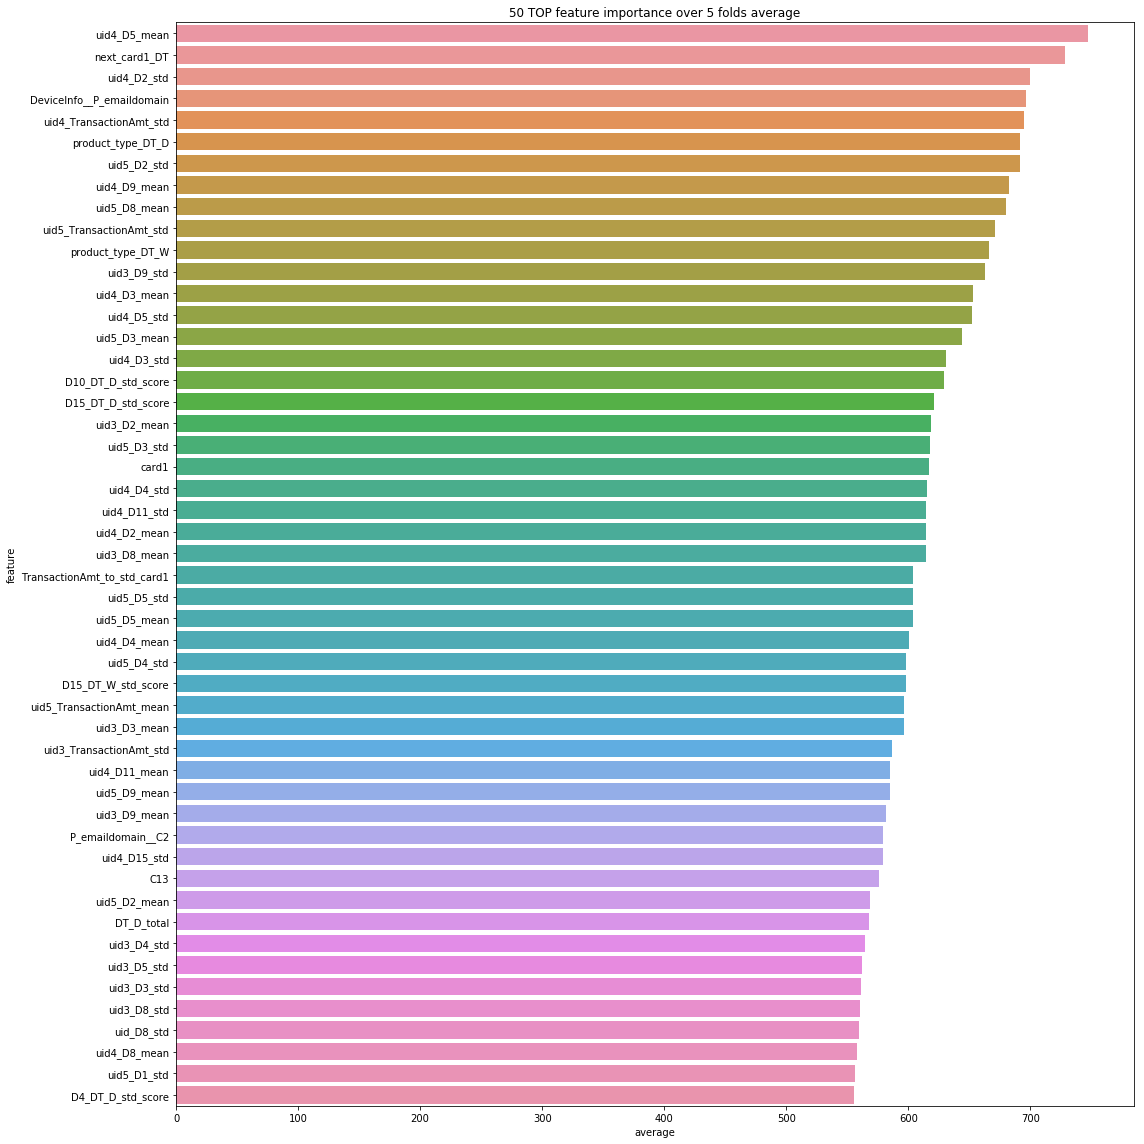

In [95]:
feature_importance['average'] = feature_importance[[f'fold_{i + 1}' for i in range(kf.n_splits)]].mean(axis=1)
# feature_importance.to_csv(f'./outputs/feature_importances_{today}.csv')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title(f'50 TOP feature importance over {kf.n_splits} folds average')
plt.tight_layout()
plt.savefig(f'./outputs/feature_importance/FI_{today}_{score:.4f}.png', dpi=150)
#plt.savefig(f'./outputs/feature_importances_{today}_smirnov05', dpi=150)

## 学習データ全体で再度モデル構築

In [100]:
clf_all = lgb.LGBMClassifier(**params, num_boost_round=int(np.floor(clf.best_iteration * 1.25)))
clf_all.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.007, max_bin=255,
               max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=80000,
               n_jobs=-1, num_boost_round=2536, num_leaves=256,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=185, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1,
               tree_learner='serial', verbose=-1)

In [101]:
submission = sample_sub.copy()
submission['isFraud'] = clf_all.predict_proba(X_test)[:, 1]
#submission.to_csv(f'./outputs/prediction_/LGB_{today}_{score:.4f}.csv', index=False)
submission.to_csv(f'./outputs/prediction_target_enc/LGB_{today}_{score:.5f}.csv', index=False)
#submission.to_csv(f'./outputs/LGB_{today}_{score:.4f}_smirnov05.csv', index=False)